In [15]:
import argparse
import pandas as pd
import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")

In [16]:
# graph load
with open('dummy_graph', 'r', encoding='utf-8') as f:
    causal_graph_gml = f.read()

# data load
df = pd.read_csv('dummy_data.csv')

In [17]:
# causal model load 
model = CausalModel(
            data=df,
            treatment='ACCR_CD',
            outcome='ACQ_180_YN',
            graph=causal_graph_gml
        )
model

In [18]:
# 1. 인과 효과 식별 (Identify)
# 그래프 구조에 기반하여 인과 효과를 통계적으로 어떻게 추정할지 결정합니다
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("\n[단계 1] 인과 효과 식별 완료.")
print(identified_estimand)


# 2. 인과 효과 추정 (Estimate)
# 식별된 방법에 따라 실제 데이터로 인과 효과의 크기를 추정합니다.
# 여기서는 간단한 선형회귀 모델을 사용합니다.

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
print("\n[단계 2] 인과 효과 추정 완료.")
print(f"  - 추정된 인과 효과 (ATE): {estimate.value:.4f}")


[단계 1] 인과 효과 식별 완료.
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                    
──────────(E[ACQ_180_YN])
d[ACCR_CD]               
Estimand assumption 1, Unconfoundedness: If U→{ACCR_CD} and U→ACQ_180_YN then P(ACQ_180_YN|ACCR_CD,,U) = P(ACQ_180_YN|ACCR_CD,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                    
──────────(E[ACQ_180_YN])
d[ACCR_CD]               
Estimand assumption 1, Unconfoundedness: If U→{ACCR_CD} and U→ACQ_180_YN then P(ACQ_180_YN|ACCR_CD,,U) = P(ACQ_180_YN|ACCR_CD,)


[단계 2] 인과 효과 추정 완료.
  - 추정된 인과 효과 (ATE): 0.0870


In [19]:
# 3. 검증 (Refute)
# 추정된 인과 효과가 강건한지 다양한 방법으로 테스트합니다.
print("\n[단계 3] 추정치에 대한 강건성 검증 수행.")

# [검증 1] 가상 원인 테스트 (Placebo Treatment)
try:
    refute_placebo = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="placebo_treatment_refuter",  # or "placebo_treatment" on some versions
        placebo_type="permute",                   # 기존 treatment를 행단위 섞어서 가상 처치 생성
        num_simulations=100
    )
    print("\n[검증 1] 가상 원인(Placebo Treatment) 테스트 결과:")
    # 공통 출력 필드
    print(f"  - 기존 추정치(estimated_effect): {refute_placebo.estimated_effect:.6f}")
    print(f"  - 가상처치 후 추정치(new_effect): {refute_placebo.new_effect:.6f}")
    # p-value가 존재하는 refuter에 한해 접근 (없으면 getattr로 안전 처리)
    pval = getattr(refute_placebo, "p_value", None)
    if pval is not None:
        # 일부 버전에선 (low, high) 구간으로 반환될 수 있음
        try:
            print(f"  - P-value: {float(pval):.4f}")
            sig = (pval <= 0.05)
        except Exception:
            print(f"  - P-value(구간): {pval}")
            # 구간이면 보수적으로 유의성 판단 생략
            sig = None

        if sig is None:
            print("  - 해석: P-value가 구간 형태입니다. 시뮬레이션 수를 늘려 정밀도 개선을 고려하세요.")
        elif not sig:
            print("  - 해석: 가상 원인의 효과가 0과 통계적으로 다르지 않습니다 → 추정이 음성대조(placebo)를 통과. 👍")
        else:
            print("  - 해석: 가상 원인이 유의함 → 식별/추정 설정 재점검 필요. 👎")
    else:
        print("  - 참고: 이 refuter는 p-value를 제공하지 않을 수 있습니다.")
except Exception as e:
    print(f"\n  - 오류 (가상 원인 테스트): {e}")

# [검증 2] 미관측 공통 원인 추가 (Sensitivity)
try:
    refute_unobserved = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="add_unobserved_common_cause",
        # 효과 형태 지정
        confounders_effect_on_treatment="binary_flip",  # 이진 처치: 확률로 뒤집기
        confounders_effect_on_outcome="linear",         # 연속형 결과: 선형 효과
        # 효과 세기(강도) 지정
        effect_strength_on_treatment=0.10,              # flip 확률 10%
        effect_strength_on_outcome=0.10,                # 선형계수 0.10
        num_simulations=100
    )
    print("\n[검증 2] 미관측 공통 원인(Unobserved Common Cause) 추가 테스트 결과:")
    print(f"  - 기존 추정치(estimated_effect): {refute_unobserved.estimated_effect:.6f}")
    print(f"  - 교란 추가 후 추정치(new_effect): {refute_unobserved.new_effect:.6f}")
    print("  - 해석: new_effect가 크게 변하지 않으면, 미관측 교란에 비교적 강건한 것으로 해석할 수 있습니다.")
    print("          (단, 본 테스트는 p-value를 제공하지 않는 민감도 분석입니다.)")
except Exception as e:
    print(f"\n  - 오류 (미관측 공통 원인 테스트): {e}")

print("\n--- 검증 완료 ---")



[단계 3] 추정치에 대한 강건성 검증 수행.

[검증 1] 가상 원인(Placebo Treatment) 테스트 결과:
  - 기존 추정치(estimated_effect): 0.086957
  - 가상처치 후 추정치(new_effect): 0.011594
  - 참고: 이 refuter는 p-value를 제공하지 않을 수 있습니다.

[검증 2] 미관측 공통 원인(Unobserved Common Cause) 추가 테스트 결과:
  - 기존 추정치(estimated_effect): 0.086957
  - 교란 추가 후 추정치(new_effect): 0.106038
  - 해석: new_effect가 크게 변하지 않으면, 미관측 교란에 비교적 강건한 것으로 해석할 수 있습니다.
          (단, 본 테스트는 p-value를 제공하지 않는 민감도 분석입니다.)

--- 검증 완료 ---


In [ ]:
import numpy as np

grid = np.linspace(0.0, 0.5, 11)  # 0%~50% 강도
rows = []
for et in grid:                   # effect_strength_on_treatment
    for eo in grid:               # effect_strength_on_outcome
        ref = model.refute_estimate(
            identified_estimand, estimate,
            method_name="add_unobserved_common_cause",
            confounders_effect_on_treatment="binary_flip",
            confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=et,
            effect_strength_on_outcome=eo,
            num_simulations=200
        )
        rows.append((et, eo, ref.new_effect))
# rows를 DataFrame으로 만들어 heatmap/contour로 시각화하면 tipping point 파악 용이

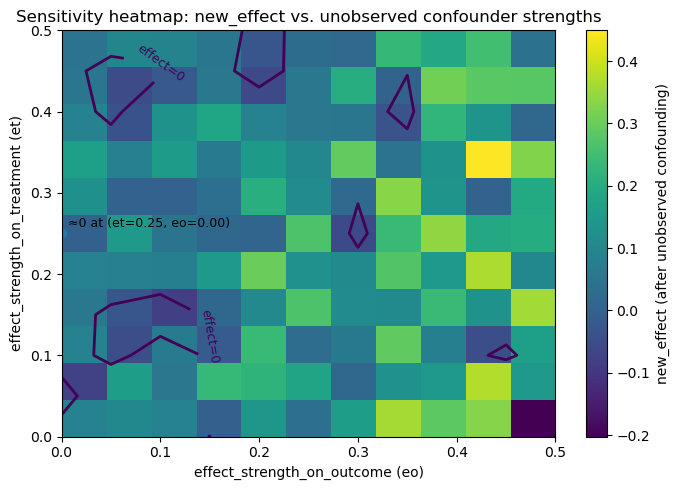

In [23]:
# --- 시각화 준비 ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) rows -> DataFrame
df = pd.DataFrame(rows, columns=["effect_strength_on_treatment", "effect_strength_on_outcome", "new_effect"])

# 2) 피벗(행: 처치 강도 et, 열: 결과 강도 eo, 값: new_effect)
pivot = df.pivot(index="effect_strength_on_treatment",
                 columns="effect_strength_on_outcome",
                 values="new_effect").sort_index(ascending=True)

# 3) 히트맵
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(
    pivot.values,
    origin="lower",  # (0,0)이 좌하단에 오도록
    aspect="auto",
    extent=[pivot.columns.min(), pivot.columns.max(),
            pivot.index.min(), pivot.index.max()]
)

# 4) 색상막대
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("new_effect (after unobserved confounding)")

# 5) 0-컨투어(효과가 0이 되는 'tipping line')
#    contour는 x=열(eo), y=행(et) 순서
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
CS = ax.contour(X, Y, pivot.values, levels=[0.0], linewidths=2)
ax.clabel(CS, inline=True, fmt="effect=0", fontsize=9)

# 6) 최소 절대값 지점(효과 크기가 가장 0에 가까운 곳) 마커 표시
abs_min_idx = np.unravel_index(np.nanargmin(np.abs(pivot.values)), pivot.values.shape)
et_star = pivot.index.values[abs_min_idx[0]]
eo_star = pivot.columns.values[abs_min_idx[1]]
ax.plot(eo_star, et_star, marker="o", markersize=6)
ax.annotate(f"≈0 at (et={et_star:.2f}, eo={eo_star:.2f})",
            (eo_star, et_star), xytext=(5, 5), textcoords="offset points", fontsize=9)

# 7) 축/제목
ax.set_xlabel("effect_strength_on_outcome (eo)")
ax.set_ylabel("effect_strength_on_treatment (et)")
ax.set_title("Sensitivity heatmap: new_effect vs. unobserved confounder strengths")

plt.tight_layout()
plt.show()


In [ ]:
# 부분표본 안정성(data_subset_refuter) 
# 표본의 변동에 얼마나 민감한지 확인합니다.
r_subset = model.refute_estimate(
    identified_estimand, estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8,
    num_simulations=200,
    random_state=42
)
print(r_subset)

In [ ]:
# Random/Dummy Outcome 추가
# 모델이 “아무 의미 없는 결과변수”에서도 신호를 뽑지 않는지 확인.
r_dummy = model.refute_estimate(
    identified_estimand, estimate,
    method_name="dummy_outcome",
    num_simulations=200
)
print(r_dummy)
